## Download the Kaggle Dataset
[H&M Personalized Fashion Recommendations](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview)

In [3]:
# Install opendatasets
!pip -q install opendatasets
## -q represents the quit, not printing out thing when installing the library
import opendatasets as od

import os
import random
import matplotlib.pyplot as plt
from PIL import Image

1. Kaggle username can be found in the **Account** tab of the **Your Profile** section.
2. Under the **Account** tab of the **Your Profile** section and click on **Create New API Token**. This will download a kaggle.json file.

In [4]:
od.download("https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data")

Skipping, found downloaded files in "./h-and-m-personalized-fashion-recommendations" (use force=True to force download)


In [5]:
!ls -lah h-and-m-personalized-fashion-recommendations

total 29G
drwxr-xr-x  3 jupyter jupyter 4.0K Oct  5 17:12 .
drwxr-xr-x  5 jupyter jupyter 4.0K Oct  5 17:25 ..
-rw-r--r--  1 jupyter jupyter  35M Oct  5 17:12 articles.csv
-rw-r--r--  1 jupyter jupyter 198M Oct  5 17:12 customers.csv
-rw-r--r--  1 jupyter jupyter  29G Oct  5 17:12 h-and-m-personalized-fashion-recommendations.zip
drwxr-xr-x 59 jupyter jupyter 4.0K Oct  5 17:24 images


### Copy the data files (*.csv) to your bucket:
Modify the bucket name to yours...

In [6]:
!gsutil -m cp h-and-m-personalized-fashion-recommendations/*.csv gs://ba-775-vj/data/h_and_m

Copying file://h-and-m-personalized-fashion-recommendations/articles.csv [Content-Type=text/csv]...
Copying file://h-and-m-personalized-fashion-recommendations/customers.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [2/2 files][232.0 MiB/232.0 MiB] 100% Done                                    
Operation completed over 2 objec

In [8]:
# If you weren't able to download the data from Kaggle you can uncomment the line below and update your bucket name:
!gsutil -m cp gs://ba-775-vj/data/h_and_m/*.csv gs://ba-775-vj/h_and_m/

Copying gs://ba-775-vj/data/h_and_m/customers.csv [Content-Type=text/csv]...
Copying gs://ba-775-vj/data/h_and_m/articles.csv [Content-Type=text/csv]...
Copying gs://ba-775-vj/data/h_and_m/transactions_train.csv [Content-Type=text/csv]...
/ [3/3 files][  3.5 GiB/  3.5 GiB] 100% Done                                    
Operation completed over 3 objects/3.5 GiB.                                      


Replace `ba-775-public` with your own bucket name:

Backup Plan

In [10]:
!gsutil -m cp gs://ba-775-public/data/h_and_m/customers.csv gs://ba-775-vj/h_and_m/
!gsutil -m cp gs://ba-775-public/data/h_and_m/articles.csv gs://ba-775-vj/h_and_m/
!gsutil -m cp gs://ba-775-public/data/h_and_m/transactions.csv gs://ba-775-vj/h_and_m/

Copying gs://ba-775-public/data/h_and_m/customers.csv [Content-Type=text/csv]...
/ [1/1 files][197.5 MiB/197.5 MiB] 100% Done                                    
Operation completed over 1 objects/197.5 MiB.                                    
Copying gs://ba-775-public/data/h_and_m/articles.csv [Content-Type=text/csv]...
/ [1/1 files][ 34.4 MiB/ 34.4 MiB] 100% Done                                    
Operation completed over 1 objects/34.4 MiB.                                     
AccessDeniedException: 403 591269071335-compute@developer.gserviceaccount.com does not have storage.objects.list access to the Google Cloud Storage bucket.
CommandException: 1 file/object could not be transferred.


In [11]:
!gsutil ls gs://ba-775-vj/data/h_and_m/

gs://ba-775-vj/data/h_and_m/articles.csv
gs://ba-775-vj/data/h_and_m/customers.csv
gs://ba-775-vj/data/h_and_m/transactions_train.csv


Create a new dataset (schema) called `h_and_m`:

In [13]:
%%bigquery
CREATE SCHEMA IF NOT EXISTS h_and_m

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 989.69query/s] 


""


Create 3 tables from the 3 csv files: `articles.csv`, `customers.csv`, and `transactions_train.csv`. Make sure to replace `ba-775-public` with your own bucket name.

In [17]:
%%bigquery
LOAD DATA OVERWRITE h_and_m.articles
FROM FILES (
  format = 'CSV',
  uris = ['gs://ba-775-public/data/h_and_m/articles.csv']);

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 538.21query/s]                          


""


In [20]:
%%bigquery
LOAD DATA OVERWRITE h_and_m.customers
FROM FILES (
  format = 'CSV',
  uris = ['gs://ba-775-public/data/h_and_m/customers.csv']);

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 397.41query/s]                          


""


We'll save `transactions_train.csv` as `transactions`:

In [21]:
%%bigquery
LOAD DATA OVERWRITE h_and_m.transactions
FROM FILES (
  format = 'CSV',
  uris = ['gs://ba-775-public/data/h_and_m/transactions_train.csv']);

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1158.33query/s]                        


""


Since `transactions` table has over 31 million rows (and almost 3GB) we will create a random sample of approximately 1% of this table and work with that during our initial exploration to save cost and improve performance:

In [26]:
%%bigquery
## what does this query do? This function takes any string give large unique integer(negative or positive, reproduceable)
## Abs value, gonna be 1% of data customer to keep

CREATE OR REPLACE TABLE h_and_m.transactions_sample 
AS
SELECT * FROM h_and_m.transactions
WHERE MOD(ABS(FARM_FINGERPRINT(customer_id)),100) = 1

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 701.51query/s]                         


""


## Exploring the `articles` table

In [27]:
%%bigquery
SELECT * FROM h_and_m.articles LIMIT 3

Downloading: 100%|██████████| 3/3 [00:01<00:00,  1.93rows/s]


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,448831026,448831,Tom Solid,59,Swimwear bottom,Swimwear,1010016,Solid,63,Dark Purple,...,Swimwear,F,Menswear,3,Menswear,26,Men Underwear,1018,Swimwear,Short swim shorts with an elasticated drawstri...
1,510264001,510264,Carl covered,59,Swimwear bottom,Swimwear,1010005,Colour blocking,63,Dark Purple,...,Swimwear,F,Menswear,3,Menswear,26,Men Underwear,1018,Swimwear,Short swim shorts with an elasticated drawstri...
2,566941026,566941,Tom solid,59,Swimwear bottom,Swimwear,1010016,Solid,20,Other Yellow,...,Swimwear,F,Menswear,3,Menswear,26,Men Underwear,1018,Swimwear,Swim shorts in woven fabric with an elasticate...


###  Display some of the images

Total number of files in images:  40114


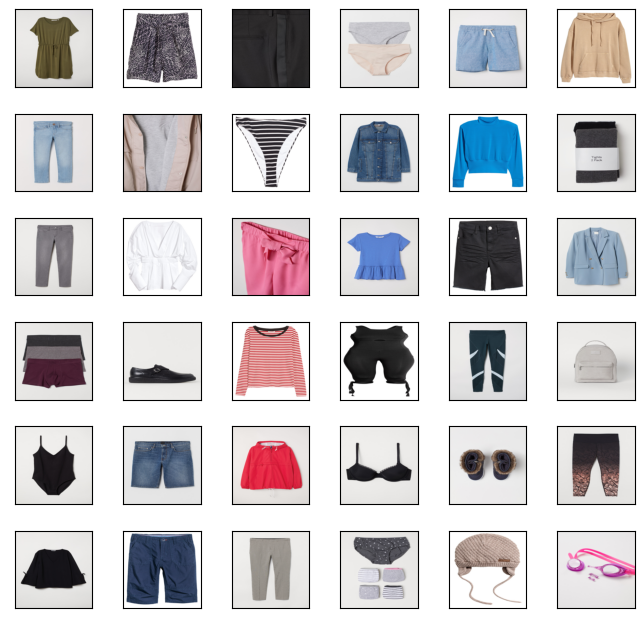

In [25]:
filenames = []
for path, subdirs, files in os.walk('h-and-m-personalized-fashion-recommendations/images'):
    for name in files:
        filenames.append(os.path.join(path, name))
print('Total number of files in images: ', len(filenames))

random.seed(10)
sample_images = random.sample(filenames, 36)

fig, axes = plt.subplots(6, 6, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.4))

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(sample_images[i]).resize((180, 180)))
    #ax.set_title(sample_images[i]) 

How many unique articles/products/etc are in this table?

In [28]:
%%bigquery
SELECT
  COUNT(*) AS n_rows,
  COUNT(DISTINCT article_id) AS article_id, 
  COUNT(DISTINCT product_code) AS product_code,
  COUNT(DISTINCT prod_name) AS prod_name,
  COUNT(DISTINCT product_type_no) AS product_type_no,
  COUNT(DISTINCT product_type_name) AS product_type_name,
  COUNT(DISTINCT product_group_name) AS product_group_name,
  COUNT(DISTINCT graphical_appearance_no) AS graphical_appearance_no,
  COUNT(DISTINCT graphical_appearance_name) AS graphical_appearance_name,
  COUNT(DISTINCT colour_group_code) AS colour_group_code,
  COUNT(DISTINCT colour_group_name) AS colour_group_name,
  COUNT(DISTINCT department_no) AS department_no,
  COUNT(DISTINCT department_name) AS department_name,
  COUNT(DISTINCT index_code) AS index_code,
  COUNT(DISTINCT index_name) AS index_name,
  COUNT(DISTINCT index_group_no) AS index_group_no,
  COUNT(DISTINCT index_group_name) AS index_group_name,
  COUNT(DISTINCT section_no) AS section_no,
  COUNT(DISTINCT section_name) AS section_name,
  COUNT(DISTINCT garment_group_no) AS garment_group_no,
  COUNT(DISTINCT garment_group_name) AS garment_group_name
FROM h_and_m.articles

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.43s/rows]


,n_rows,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,...,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name
0,105542,105542,47224,45875,132,131,19,30,30,50,...,299,250,10,10,5,5,57,56,21,21


Can you investigate and figure out what the difference between `article_id` and `product_code` is?

In [30]:
%%bigquery
SELECT 
  product_code, count(DISTINCT article_id) n_articles
FROM h_and_m.articles
GROUP BY product_code
ORDER BY n_articles DESC

Downloading: 100%|██████████| 47224/47224 [00:01<00:00, 43057.14rows/s]


,product_code,n_articles
0,783707,75
1,684021,70
2,699923,52
3,699755,49
4,685604,46
...,...,...
47219,595949,1
47220,644071,1
47221,714373,1
47222,714376,1


In [31]:
%%bigquery
SELECT
  COUNT(*) AS n_rows,
  COUNT(DISTINCT article_id) AS article_id, 
  COUNT(DISTINCT product_code) AS product_code,
  COUNT(DISTINCT prod_name) AS prod_name,
  COUNT(DISTINCT product_type_no) AS product_type_no,
  COUNT(DISTINCT product_type_name) AS product_type_name,
  COUNT(DISTINCT product_group_name) AS product_group_name,
  COUNT(DISTINCT graphical_appearance_no) AS graphical_appearance_no,
  COUNT(DISTINCT graphical_appearance_name) AS graphical_appearance_name,
  COUNT(DISTINCT colour_group_code) AS colour_group_code,
  COUNT(DISTINCT colour_group_name) AS colour_group_name,
  COUNT(DISTINCT department_no) AS department_no,
  COUNT(DISTINCT department_name) AS department_name,
  COUNT(DISTINCT index_code) AS index_code,
  COUNT(DISTINCT index_name) AS index_name,
  COUNT(DISTINCT index_group_no) AS index_group_no,
  COUNT(DISTINCT index_group_name) AS index_group_name,
  COUNT(DISTINCT section_no) AS section_no,
  COUNT(DISTINCT section_name) AS section_name,
  COUNT(DISTINCT garment_group_no) AS garment_group_no,
  COUNT(DISTINCT garment_group_name) AS garment_group_name
FROM h_and_m.articles
WHERE product_code = 783707

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.60s/rows]


,n_rows,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,...,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name
0,75,75,1,3,1,1,1,3,3,23,...,1,1,1,1,1,1,1,1,1,1


In [32]:
%%bigquery
SELECT
  STRING_AGG(DISTINCT prod_name) prod_name,
  STRING_AGG(DISTINCT CAST(graphical_appearance_no AS STRING)) graphical_appearance_no,
  STRING_AGG(DISTINCT graphical_appearance_name) graphical_appearance_name,
  STRING_AGG(DISTINCT CAST(colour_group_code AS STRING)) colour_group_code,
  STRING_AGG(DISTINCT colour_group_name) colour_group_name,
  COUNT(DISTINCT detail_desc) AS n_detail_desc
FROM h_and_m.articles
WHERE product_code = 783707

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.50s/rows]


,prod_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,n_detail_desc
0,"1pk Fun 1,1pk Fun,1pk fun sock","1010001,1010022,1010014","All over pattern,Jacquard,Placement print","82,63,83,62,6,7,8,9,10,13,19,21,32,33,42,52,61...","Turquoise,Dark Purple,Dark Turquoise,Purple,Li...",1


In [34]:
files_0783707 = !ls h-and-m-personalized-fashion-recommendations/images/078/0783707*
len(files_0783707)

1

FileNotFoundError: [Errno 2] No such file or directory: "ls: cannot access 'h-and-m-personalized-fashion-recommendations/images/078/0783707*': No such file or directory"

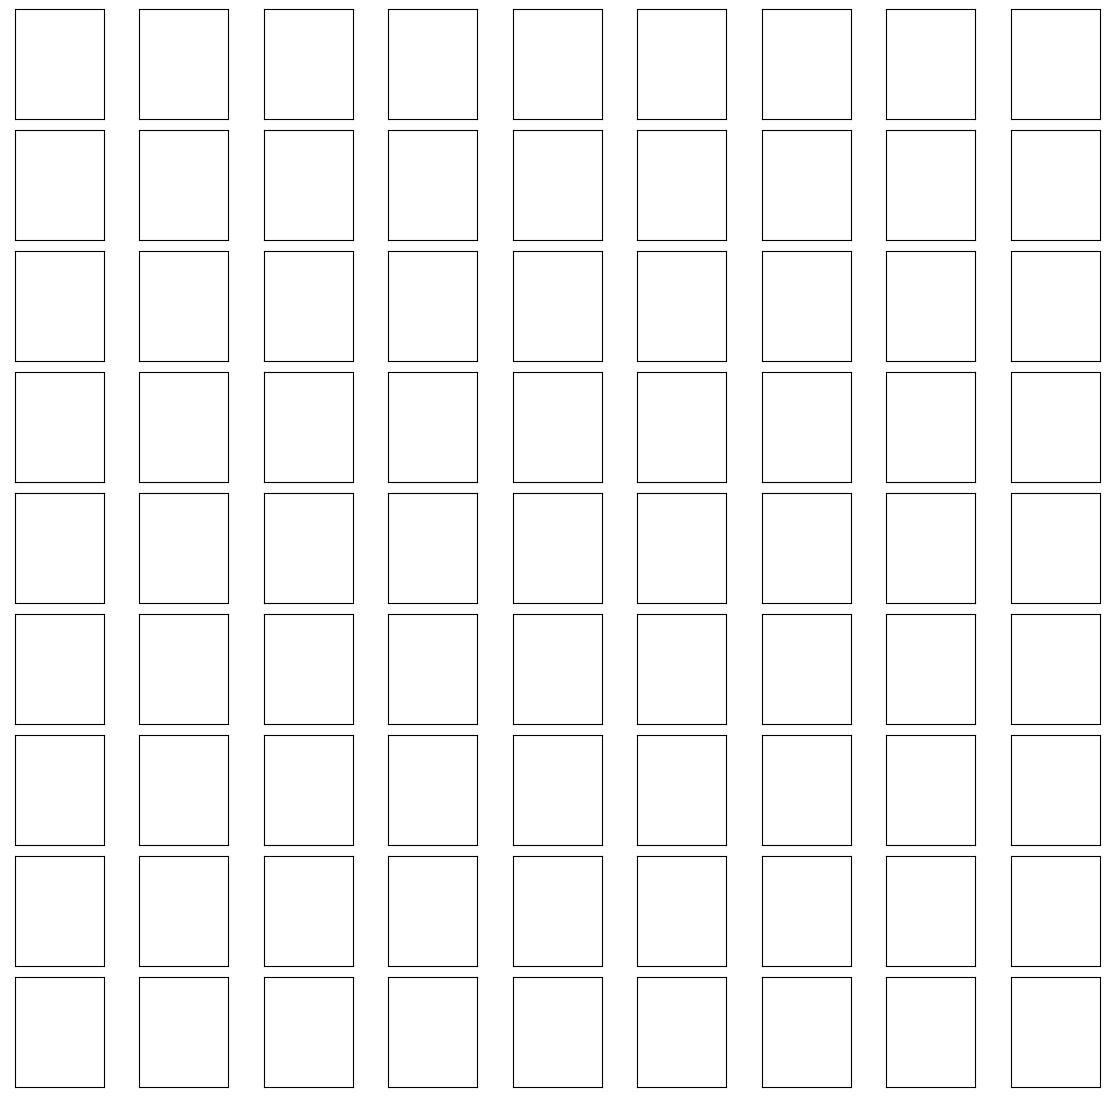

In [47]:
fig, axes = plt.subplots(9, 9, figsize=(14, 14),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.4))

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(files_0783707[i]).resize((180, 180)))
    ax.set_title(files_0783707[i][56:-4]) 
    if i == len(files_0783707)-1:
        break

### What is the breakdown of `index_name`?

In [ ]:
%%bigquery
SELECT 
  index_name, count(article_id) n_articles
FROM h_and_m.articles
GROUP BY index_name
ORDER BY n_articles DESC

### What is the breakdown of `index_group_name`?

In [48]:
%%bigquery
SELECT 
  index_group_name, 
  count(article_id) n_articles, 
  COUNT(DISTINCT index_name) n_index_name, STRING_AGG(DISTINCT index_name) index_name,
  COUNT(DISTINCT garment_group_name) n_garment_group_name, STRING_AGG(DISTINCT garment_group_name) garment_group_name
FROM h_and_m.articles
GROUP BY index_group_name
ORDER BY n_articles DESC

Downloading: 100%|██████████| 5/5 [00:01<00:00,  2.78rows/s]


,index_group_name,n_articles,n_index_name,index_name,n_garment_group_name,garment_group_name
0,Ladieswear,39737,3,"Ladieswear,Lingeries/Tights,Ladies Accessories",18,"Unknown,Special Offers,Socks and Tights,Dresse..."
1,Baby/Children,34711,4,"Children Sizes 134-170,Children Sizes 92-140,B...",17,"Dresses/Skirts girls,Jersey Fancy,Trousers,Kni..."
2,Divided,15149,1,Divided,16,"Blouses,Dresses Ladies,Unknown,Outdoor,Jersey ..."
3,Menswear,12553,1,Menswear,16,"Swimwear,Accessories,Under-, Nightwear,Dressed..."
4,Sport,3392,1,Sport,5,"Outdoor,Jersey Fancy,Accessories,Unknown,Trousers"


In [38]:
%%bigquery
SELECT 
  index_group_name, garment_group_name,
  count(article_id) n_articles, 
FROM h_and_m.articles
GROUP BY index_group_name, garment_group_name
ORDER BY n_articles DESC

Downloading: 100%|██████████| 72/72 [00:01<00:00, 54.09rows/s]


,index_group_name,garment_group_name,n_articles
0,Baby/Children,Jersey Fancy,9103
1,Ladieswear,Jersey Fancy,6163
2,Ladieswear,Accessories,4999
3,Ladieswear,"Under-, Nightwear",4513
4,Ladieswear,Blouses,4492
...,...,...,...
67,Divided,Special Offers,148
68,Divided,Swimwear,76
69,Baby/Children,Unknown,59
70,Menswear,Special Offers,25


## Exploring the `customers` table

In [39]:
%%bigquery
SELECT * FROM h_and_m.customers LIMIT 3

Downloading: 100%|██████████| 3/3 [00:01<00:00,  1.79rows/s]


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,09a3dd9b174ce39cdfe1e8b5ec47167c8cc604928eec20...,1.0,1.0,PRE-CREATE,Monthly,65,b97439bfd3a833f9ef16537af6693c07493646d57b6191...
1,1608504257feb3b38b3700a081e12d2b1901c9b7d9be6d...,1.0,1.0,PRE-CREATE,Monthly,66,8fc2e6694f5b0fe6bcd212965cd9024e333e6c65473caf...
2,1e033264a3b552fe88bdcce44174dff8b4cfc58dad529c...,1.0,1.0,ACTIVE,Monthly,77,2df2189d6fefc69255504d4640f44adc849bd899bc2a3c...


What is the age demographic of the customers?

In [40]:
%%bigquery
SELECT
   CASE
       WHEN age >= 90 THEN '90s'
       WHEN age >= 80 THEN '80s'
       WHEN age >= 70 THEN '70s'
       WHEN age >= 60 THEN '60s'
       WHEN age >= 50 THEN '50s'
       WHEN age >= 40 THEN '40s'
       WHEN age >= 30 THEN '30s'
       WHEN age >= 20 THEN '20s'
       WHEN age >= 10 THEN '10s'
       ELSE 'Unknown'
   END AS age,
   count(*) AS n_customers
FROM h_and_m.customers
GROUP BY 1
ORDER BY 1

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.92rows/s]


,age,n_customers
0,10s,71583
1,20s,528358
2,30s,234068
3,40s,204118
4,50s,226242
5,60s,72623
6,70s,17611
7,80s,1415
8,90s,101
9,Unknown,15861


## Exploring the `transactions` table

In [41]:
%%bigquery
SELECT * FROM h_and_m.transactions_sample LIMIT 3

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.04rows/s]


,t_dat,customer_id,article_id,price,sales_channel_id
0,2019-01-24,02354fba443ecfd9914e9f842fe8a61e7e367cf6dd7057...,189616001,0.016932,2
1,2019-01-24,02354fba443ecfd9914e9f842fe8a61e7e367cf6dd7057...,571706001,0.022017,2
2,2019-01-24,02354fba443ecfd9914e9f842fe8a61e7e367cf6dd7057...,571706001,0.022017,2


In [42]:
%%bigquery
SELECT min(t_dat), max(t_dat) FROM h_and_m.transactions_sample

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.49s/rows]


,f0_,f1_
0,2018-09-20,2020-09-22


Top 10 customers by num of transactions:

In [43]:
%%bigquery
SELECT customer_id, count(*) n_transactions
FROM h_and_m.transactions_sample
GROUP BY customer_id
ORDER BY n_transactions DESC
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  7.74rows/s]


,customer_id,n_transactions
0,d80ed4ababfa96812e22b911629e6bcbf5093769051ea4...,1066
1,e3717b1d03c73d1cfd0f27ef09c32381aab5ca11c5aed9...,592
2,4e57c43d931e365659f756e5b173b79b9fdc8cbc6a5eab...,587
3,578e704b2c2fc32d93261b4be9d4797301518f653a9c17...,511
4,0d8e6c1ea7890ce90968f017361e439f4ea9091de795e9...,503
5,2d545e697d8cf36558c81eb56c1776cb30f893585ed21a...,479
6,66fc1a29a90f01fe4d9b5e6f00d3e6fc803a4b5ffafbc7...,475
7,392d4ed7fe2b4b6bdf61f4ef1b6f9b614ce7c7d8052c60...,456
8,6b5851409a9ca9c54033fea3c354b7277b369fc0e61775...,437
9,2fd690c02e3f0a1def03a331bfbb133f0d0790af4f013f...,437


Top 10 customers by revenue:

In [44]:
%%bigquery
SELECT customer_id, sum(price) revenue
FROM h_and_m.transactions_sample
GROUP BY customer_id
ORDER BY revenue DESC
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.79rows/s]


,customer_id,revenue
0,d80ed4ababfa96812e22b911629e6bcbf5093769051ea4...,39.821627
1,0d8e6c1ea7890ce90968f017361e439f4ea9091de795e9...,21.904220
2,4e57c43d931e365659f756e5b173b79b9fdc8cbc6a5eab...,18.525424
3,e3717b1d03c73d1cfd0f27ef09c32381aab5ca11c5aed9...,18.267475
4,578e704b2c2fc32d93261b4be9d4797301518f653a9c17...,17.440424
5,9e6b6c5bfb5fa347204dbd93f51d84be5fa631a09226ff...,16.356339
6,419d24b577b25ebf4e60feb39ff0466e6d7752f8ba02d1...,15.557136
7,42fd70f36a393442030b07e9fbc74c9fe8aac1769be4b4...,14.417780
8,2fd690c02e3f0a1def03a331bfbb133f0d0790af4f013f...,14.283678
9,6d1d3142514e6376099fa031d1cf16b8fb7a40060d881e...,13.827407


What are the top 5 `product_code` and `product_type_name`?

In [45]:
%%bigquery
SELECT product_code, product_type_name, sum(price) revenue FROM
(
  SELECT A.*, B.product_code, B.product_type_name
  FROM h_and_m.transactions_sample A
  LEFT JOIN h_and_m.articles B
  USING(article_id)
)
GROUP BY product_code, product_type_name
ORDER BY revenue DESC
LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.61rows/s]


,product_code,product_type_name,revenue
0,706016,Trousers,63.970915
1,562245,Trousers,43.974288
2,399201,Trousers,35.710186
3,568601,Blazer,26.576068
4,554450,Trousers,24.721458


How about `product_group_name`?

In [46]:
%%bigquery
SELECT product_group_name, sum(price) revenue FROM
(
  SELECT A.*, B.product_group_name
  FROM h_and_m.transactions_sample A
  LEFT JOIN h_and_m.articles B
  USING(article_id)
)
GROUP BY product_group_name
ORDER BY revenue DESC
LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.36rows/s]


,product_group_name,revenue
0,Garment Upper body,3418.268915
1,Garment Lower body,2348.618763
2,Garment Full body,1266.220797
3,Swimwear,577.979271
4,Underwear,537.535017
